In [1]:
import jax
import jax.numpy as jnp
from jax.lax import fori_loop, cond, scan
from jax import vmap, jit
from scipy.sparse import csc_matrix, identity
from scipy.sparse.linalg import cg, gmres
import math
import numpy as np
import matplotlib.pyplot as plt
from functools import partial

# Create mesh

In [2]:
r_earth = 6400.0  # in km; wavenumbers will be in 1/km
Lx = 1000  # km      Use 1020 and 1022 for dxm=4 and 2.
Ly = Lx
dxm = 5
dym = dxm
cyclic = 0  # 1 if mesh is cyclic
cyclic_length = 360  # in degrees; if not cyclic, take it larger than  zonal size
cyclic_length = cyclic_length * math.pi / 180  # DO NOT TOUCH
meshtype = 'm'  # coordinates can be in physical measure 'm' or in radians 'r'
cartesian = True

In [3]:
xx = np.arange(0, Lx + 1, dxm, dtype="float32")
yy = np.arange(0, Ly + 1, dym, dtype="float32")

# Create uniformity in the mesh
# xx = np.concatenate((np.arange(0, 4*Lx//20 + 1, dxm), np.arange(5*Lx//20, Lx + 1, dxm)))
# yy = np.concatenate((np.arange(0, 4*Ly//20 + 1, dym), np.arange(5*Ly//20, Ly + 1, dym)))

nx = len(xx)
ny = len(yy)

nodnum = np.arange(0, nx * ny)
xcoord = np.tile(xx, reps=(ny, 1)).T
ycoord = np.tile(yy, reps=(nx, 1))


# Create random data with given spectra

In [4]:
@jit
def make_ll(x, y):
    return jnp.sqrt(y * y + x * x)

@jit
def make_tff(ttf, ll):
    return ttf / (jnp.power(ll, 1.5))  # 1.5 for -2 spectrum

tt = 50 * (np.random.random(xcoord.shape) - 0.5)
ttf = np.fft.fft2(tt)
# ============
# Make spectrum red
# ============
espectrum = np.zeros((nx // 2 + 1))  # Place for Fourier spectrum
kk = np.concatenate((np.arange(0, nx // 2 + 1), np.arange(-nx // 2 + 1, 0, 1)))  # Wavenumbers

ll = vmap(vmap(make_ll, in_axes=(None, 0)), in_axes=(0, None))(kk, kk)
ttf = vmap(vmap(make_tff, in_axes=(0, 0)), in_axes=(0, 0))(ttf, ll)
ttf = ttf.at[0, 0].set(0.0)

tt = jnp.real(jnp.fft.ifft2(ttf))

In [5]:
# == == == == == == == =
# Reshape to 1D arrays
# == == == == == == == =
nodnum = np.reshape(nodnum, [ny, nx]).T
xcoord = np.reshape(xcoord, [nx * ny])
ycoord = np.reshape(ycoord, [nx * ny])
tt = np.reshape(tt, [nx * ny])

# Optional: convert mesh and data to spherical geometry

In [6]:
cartesian = False

xcoord /= r_earth
ycoord /= r_earth
alpha = math.pi/3 + math.pi/12
zg = np.sin(ycoord)
xg = np.cos(ycoord) * np.cos(xcoord)
yg = np.cos(ycoord) * np.sin(xcoord)
# Rotate by alpha
zn = zg * np.cos(alpha) + xg * np.sin(alpha)
xg = -zg * np.sin(alpha) + xg * np.cos(alpha)
# New coordinates in radians
ycoord = np.arcsin(zn)
xcoord = np.arctan2(yg,xg)
# New coordinates in degrees
ycoord = (180/math.pi) * np.arcsin(zn)
xcoord = (180/math.pi) * np.arctan2(yg,xg)


# Create triangulation

In [7]:
def make_tri(nodnum: jnp.ndarray, nx: int, ny: int):
    def make_tri(n, nn):
        return jnp.array([nodnum[nn, n], nodnum[nn+1, n], nodnum[nn, n+1]]), jnp.array([nodnum[nn+1, n], nodnum[nn+1, n+1], nodnum[nn, n+1]])

    b = jnp.reshape(vmap(lambda i: jnp.tile(i, nx-1))(jnp.arange(ny-1)), [(nx-1)*(ny-1)])
    a = jnp.tile(jnp.arange(nx-1), nx-1)

    tri = vmap(make_tri)(b, a)
    return jnp.reshape(jnp.concatenate((tri[0], tri[1]), axis=1), [2*(nx-1)*(ny-1), 3])

make_tri = jit(make_tri, static_argnums=[1, 2])

In [8]:
tri = make_tri(nodnum, nx, ny)
tri = np.array(tri)
n2d = len(xcoord)  # The number of vertices(nodes)
e2d = len(tri[:, 1])  # The number of triangles(elements)

In [9]:
tri

array([[    0,     1,   201],
       [    1,   202,   201],
       [    1,     2,   202],
       ...,
       [40198, 40399, 40398],
       [40198, 40199, 40399],
       [40199, 40400, 40399]], dtype=int32)

# Create auxilliary arrays for the filter

In [10]:
def neighboring_triangles(n2d: int, e2d: int, tri: np.ndarray):
    """
    Calculate neighboring triangles for each node in a 2D mesh.

    Parameters:
    ----------
    n2d : int
        The total number of nodes in the mesh.

    e2d : int
        The total number of triangles (elements) in the mesh.

    tri : np.ndarray
        A 2D NumPy array representing the connectivity of triangles (elements) in the mesh.
        Each row contains the indices of the three nodes that form a triangle.

    Returns:
    -------
    ne_num : np.ndarray
        A 1D NumPy array of shape (n2d,) containing the count of neighboring triangles for each node.

    ne_pos : np.ndarray
        A 2D NumPy array of shape (max_neighboring_triangles, n2d) containing the positions of neighboring
        triangles for each node. The 'ne_pos[i, j]' entry indicates the index of the i-th neighboring triangle
        for the j-th node. Unused entries are filled with zeros.
    """
    # Initialize an array to store the count of neighboring triangles for each node.
    ne_num = np.zeros([n2d], dtype=int)

    # Loop through each triangle (element) in the mesh.
    for n in range(e2d):
        enodes = tri[n, :]
        # Increment the count of neighboring triangles for each node in the current triangle.
        ne_num[enodes] += 1

    # Initialize an array to store the positions of neighboring triangles for each node.
    ne_pos = np.zeros([int(np.max(ne_num)), n2d], dtype=int)

    # Reset the array to store the count of neighboring triangles for each node.
    ne_num = np.zeros([n2d], dtype=int)

    # Loop through each triangle (element) in the mesh.
    for n in range(e2d):
        enodes = tri[n, :]
        # Loop through the nodes of the current triangle.
        for j in range(3):
            # Store the position of the current neighboring triangle for the corresponding node.
            ne_pos[ne_num[enodes[j]], enodes[j]] = n
            # Increment the count of neighboring triangles for the node.
        ne_num[enodes] += 1

    return ne_num, ne_pos

In [11]:
def neighbouring_nodes(n2d: int, tri: np.ndarray, ne_num: np.ndarray, ne_pos: np.ndarray):
    """
    Compute neighboring nodes for each node in a 2D mesh.

    Parameters:
    ----------
    n2d : int
        The total number of nodes in the mesh.

    tri : np.ndarray
        A 2D NumPy array representing the connectivity of triangles (elements) in the mesh.
        Each row contains the indices of the three nodes that form a triangle.

    ne_num : np.ndarray
        A 1D NumPy array of shape (n2d,) containing the count of neighboring triangles for each node.

    ne_pos : np.ndarray
        A 2D NumPy array of shape (max_neighboring_triangles, n2d) containing the positions of neighboring
        triangles for each node. The 'ne_pos[i, j]' entry indicates the index of the i-th neighboring triangle
        for the j-th node. Unused entries are filled with zeros.

    Returns:
    -------
    nn_num : np.ndarray
        A 1D NumPy array of shape (n2d,) containing the number of neighboring nodes for each node.

    nn_pos : np.ndarray
        A 2D NumPy array of shape (max_neighboring_nodes, n2d) containing the positions of neighboring nodes
        for each node. The 'nn_pos[i, j]' entry indicates the index of the i-th neighboring node for the j-th node.
    """
    # Initialize an array to store the count of neighboring nodes for each node.


    # Initialize an array to store the positions of neighboring nodes for each node.
    nn_num = np.zeros([n2d], dtype=int)
    check = np.zeros([n2d], dtype=int)
    aux = np.zeros([10], dtype=int)
    for j in range(n2d):
        cc = 0
        for m in range(ne_num[j]):
            el = ne_pos[m, j]
            for k in range(3):
                a = tri[el, k]
                if check[a] == 0:
                    check[a] = 1
                    aux[cc] = a
                    cc += 1

        nn_num[j] = cc
        check[aux[0:cc]] = 0

    nn_pos = np.zeros([np.max(nn_num), n2d], dtype=int)

    for j in range(n2d):
        cc = 0
        for m in range(ne_num[j]):
            el = ne_pos[m, j]
            for k in range(3):
                a = tri[el, k]
                if check[a] == 0:
                    check[a] = 1
                    aux[cc] = a
                    cc += 1

        nn_pos[0:cc, j] = aux[0:cc].T
        check[aux[0:cc]] = 0

    return nn_num, nn_pos

In [12]:
def areas(n2d: int, e2d: int, tri: np.ndarray, xcoord: np.ndarray, ycoord: np.ndarray, ne_num: np.ndarray,
          ne_pos: np.ndarray, meshtype: str, carthesian: bool, cyclic_length):
    """
    Calculate areas of triangles and derivatives of P1 basis functions.

    Parameters:
    ----------
    n2d : int
        The total number of nodes in the mesh.

    e2d : int
        The total number of triangles (elements) in the mesh.

    tri : np.ndarray
        A 2D NumPy array representing the connectivity of triangles (elements) in the mesh.
        Each row contains the indices of the three nodes that form a triangle.

    xcoord : np.ndarray
        A 1D NumPy array containing the x-coordinates of nodes in the mesh.

    ycoord : np.ndarray
        A 1D NumPy array containing the y-coordinates of nodes in the mesh.

    ne_num : np.ndarray
        A 1D NumPy array of shape (n2d,) containing the count of neighboring triangles for each node.

    ne_pos : np.ndarray
        A 2D NumPy array of shape (max_neighboring_triangles, n2d) containing the positions of neighboring
        triangles for each node. The 'ne_pos[i, j]' entry indicates the index of the i-th neighboring triangle
        for the j-th node. Unused entries are filled with zeros.

    meshtype : str
        Mesh type, either 'm' (metric) or 'r' (radial).

    carthesian : bool
        Boolean indicating whether the mesh is in Cartesian coordinates.

    cyclic_length : float
        The length of the cyclic boundary if the mesh is cyclic (for 'r' meshtype).

    Returns:
    -------
    area : np.ndarray
        A 1D NumPy array of shape (n2d,) containing the scalar cell (cluster) area for each node.

    elem_area : np.ndarray
        A 1D NumPy array of shape (e2d,) containing the area of each triangle (element) in the mesh.

    dx : np.ndarray
        A 2D NumPy array of shape (e2d, 3) containing the x-derivative of P1 basis functions for each triangle.

    dy : np.ndarray
        A 2D NumPy array of shape (e2d, 3) containing the y-derivative of P1 basis functions for each triangle.

    Mt : np.ndarray
        A 1D NumPy array of shape (e2d,) containing a factor for metric terms based on meshtype and coordinates.
    """
    dx = np.zeros([e2d, 3], dtype=float)
    dy = np.zeros([e2d, 3], dtype=float)
    elem_area = np.zeros([e2d])
    r_earth = 6400  # Earth's radius, assuming units in kilometers
    Mt = np.ones([e2d])

    if meshtype == 'm':
        for n in range(e2d):
            # Calculate differences in x and y coordinates for triangle vertices.
            x2 = xcoord[tri[n, 1]] - xcoord[tri[n, 0]]
            x3 = xcoord[tri[n, 2]] - xcoord[tri[n, 0]]
            y2 = ycoord[tri[n, 1]] - ycoord[tri[n, 0]]
            y3 = ycoord[tri[n, 2]] - ycoord[tri[n, 0]]

            # Calculate determinant of the Jacobian matrix for this triangle.
            d = x2 * y3 - y2 * x3

            # Calculate x and y derivatives of P1 basis functions.
            dx[n, 0] = (-y3 + y2) / d
            dx[n, 1] = y3 / d
            dx[n, 2] = -y2 / d

            dy[n, 0] = -(-x3 + x2) / d
            dy[n, 1] = -x3 / d
            dy[n, 2] = x2 / d

            # Calculate the area of the triangle.
            elem_area[n] = 0.5 * abs(d)

    elif meshtype == 'r':
        rad = math.pi / 180.0
        if carthesian:
            Mt = np.ones([e2d])
        else:
            Mt = np.cos(np.sum(rad * ycoord[tri], axis=1) / 3.0)

        for n in range(e2d):
            # Calculate differences in longitude and latitude for triangle vertices.
            x2 = rad * (xcoord[tri[n, 1]] - xcoord[tri[n, 0]])
            x3 = rad * (xcoord[tri[n, 2]] - xcoord[tri[n, 0]])
            y2 = r_earth * rad * (ycoord[tri[n, 1]] - ycoord[tri[n, 0]])
            y3 = r_earth * rad * (ycoord[tri[n, 2]] - ycoord[tri[n, 0]])

            # Adjust for cyclic boundaries.
            if x2 > cyclic_length / 2.0:
                x2 = x2 - cyclic_length
            if x2 < -cyclic_length / 2.0:
                x2 = x2 + cyclic_length
            if x3 > cyclic_length / 2.0:
                x3 = x3 - cyclic_length
            if x3 < -cyclic_length / 2.0:
                x3 = x3 + cyclic_length

            # Apply metric factors and calculate x and y derivatives of P1 basis functions.
            x2 = r_earth * x2 * Mt[n]
            x3 = r_earth * x3 * Mt[n]
            d = x2 * y3 - y2 * x3

            dx[n, 0] = (-y3 + y2) / d
            dx[n, 1] = y3 / d
            dx[n, 2] = -y2 / d

            dy[n, 0] = -(-x3 + x2) / d
            dy[n, 1] = -x3 / d
            dy[n, 2] = x2 / d

            # Calculate the area of the triangle.
            elem_area[n] = 0.5 * abs(d)

        if carthesian:
            Mt = np.zeros([e2d])
        else:
            Mt = (np.sin(rad * np.sum(ycoord[tri], axis=1) / 3.0) / Mt) / r_earth

    # Calculate scalar cell (cluster) area for each node.
    area = np.zeros([n2d])
    for n in range(n2d):
        area[n] = np.sum(elem_area[ne_pos[0:ne_num[n], n]]) / 3.0

    return area, elem_area, dx, dy, Mt

In [13]:
ne_num, ne_pos = neighboring_triangles(n2d, e2d, tri)
nn_num, nn_pos = neighbouring_nodes(n2d, tri, ne_num, ne_pos)
area, elem_area, dx, dy, Mt = areas(n2d, e2d, tri, xcoord, ycoord, ne_num, ne_pos, meshtype, cartesian, cyclic_length)

In [14]:
Kc = np.array([2, 2.2, 2.5, 3, 4, 5, 6, 8, 10, 12, 16, 20, 24, 30, 40, 60, 80, 100]) * dxm
Kc = 2 * math.pi / Kc  # Wavenumbers
nr = len(Kc)

In [15]:
# Move data to JAX
jKc = jnp.array(Kc)
jescaling = jnp.zeros([nr + 1])  # Place for spectrum
# # Compute total energy
jescaling.at[0].set(jnp.sum(area * jnp.square(tt)) / jnp.sum(area))
jelem_area = jnp.array(elem_area)
jdx = jnp.array(dx)
jdy = jnp.array(dy)
jnn_num = jnp.array(nn_num)
jnn_pos = jnp.array(nn_pos)
jtri = jnp.array(tri)
jarea = jnp.array(area)
jMt = jnp.array(Mt)
jtt = jnp.array(tt)

# Create Laplacian matrix

In [16]:
def make_smooth(Mt: jnp.ndarray, elem_area: jnp.ndarray, dx: jnp.ndarray, dy: jnp.ndarray, nn_num: jnp.ndarray,
                nn_pos: jnp.ndarray, tri: jnp.ndarray, n2d: int, e2d: int, full: bool = False):
    """
    Calculate the smoothness matrix and metric matrix for a given mesh.
    
    WARNING!!! This function is inherently single-threaded!. Running it on GPU will cause performance issue

    Parameters:
    ----------
    Mt : jnp.ndarray
        A 1D JAX NumPy array containing metric factors for each triangle.

    elem_area : jnp.ndarray
        A 1D JAX NumPy array containing the area of each triangle.

    dx : jnp.ndarray
        A 2D JAX NumPy array of shape (e2d, 3) containing x-derivatives of P1 basis functions.

    dy : jnp.ndarray
        A 2D JAX NumPy array of shape (e2d, 3) containing y-derivatives of P1 basis functions.

    nn_num : jnp.ndarray
        A 1D JAX NumPy array of shape (n2d,) containing the number of neighboring nodes for each node.

    nn_pos : jnp.ndarray
        A 2D JAX NumPy array of shape (max_neighboring_nodes, n2d) containing positions of neighboring nodes.

    tri : jnp.ndarray
        A 2D JAX NumPy array representing the connectivity of triangles in the mesh.

    n2d : int
        The total number of nodes in the mesh.

    e2d : int
        The total number of triangles (elements) in the mesh.

    full : bool, optional
        A flag indicating whether to use the 'full' calculation including metric factors (True) or not (False).
        Default is True.

    Returns:
    -------
    smooth_m : jnp.ndarray
        A 2D JAX NumPy array of shape (max_neighboring_nodes, n2d) containing the smoothness matrix.

    metric : jnp.ndarray
        A 2D JAX NumPy array of shape (max_neighboring_nodes, n2d) containing the metric matrix.
    """
    smooth_m = jnp.zeros(nn_pos.shape, dtype=jnp.float32)
    metric = jnp.zeros(nn_pos.shape, dtype=jnp.float32)
    aux = jnp.zeros((n2d,), dtype=jnp.int32)

    @jit
    def loop_body(j, carry):
        smooth_m, metric, aux, nn_num, nn_pos, elem_area, dx, dy, Mt = carry
        enodes = tri[j, :]

        def inner_loop_body(n, carry):
            smooth_m, metric, aux, enodes, nn_num, nn_pos, elem_area, dx, dy, Mt = carry
            row = enodes[n]
            cc = nn_num[row]

            def fill_xd(i, val):
                row, aux, nn_pos = val
                n = nn_pos[i, row]
                aux = aux.at[n].set(i)
                return row, aux, nn_pos

            row, aux, _ = fori_loop(0, cc, fill_xd, (row, aux, nn_pos))

            def update_smooth_m(m, carry):
                smooth_m, metric, aux, enodes, elem_area, dx, dy, n = carry
                col = enodes[m]
                pos = aux[col]
                tmp_x = dx[m] * dx[n]
                tmp_y = dy[n] * dy[m]
                c1 = m == n

                smooth_m = smooth_m.at[pos, row].add(cond(c1 & full,
                                                          lambda: (tmp_x + tmp_y) * elem_area + jnp.square(
                                                              Mt) * elem_area / 3.0,
                                                          lambda: (tmp_x + tmp_y) * elem_area
                                                          )
                                                     )
                metric = metric.at[pos, row].add(Mt * (dx[n] - dx[m]) * elem_area / 3.0)
                return smooth_m, metric, aux, enodes, elem_area, dx, dy, n

            smooth_m, metric, aux, _, _, _, _, _ = fori_loop(0, 3, update_smooth_m,
                                                             (smooth_m, metric, aux, enodes, elem_area, dx, dy, n))
            return smooth_m, metric, aux, enodes, nn_num, nn_pos, elem_area, dx, dy, Mt

        smooth_m, metric, aux, _, _, _, _, _, _, _ = fori_loop(0, 3, inner_loop_body, (
        smooth_m, metric, aux, enodes, nn_num, nn_pos, elem_area[j], dx[j, :], dy[j, :], Mt[j]))
        return smooth_m, metric, aux, nn_num, nn_pos, elem_area, dx, dy, Mt

    smooth_m, metric, _, _, _, _, _, _, _ = fori_loop(0, e2d, loop_body,
                                                      (smooth_m, metric, aux, nn_num, nn_pos, elem_area, dx, dy, Mt))
    return smooth_m, metric

In [17]:
@partial(jit, static_argnums=[3, 4])
def make_smat(nn_pos: jnp.ndarray, nn_num: jnp.ndarray, smooth_m: jnp.ndarray, n2d: int, nza: int):
    """
    Convert the smoothness matrix into a redundant sparse form (s(k), i(k), j(k)) as required by scipy.

    Parameters:
    ----------
    nn_pos : jnp.ndarray
        A 2D JAX NumPy array of shape (max_neighboring_nodes, n2d) containing positions of neighboring nodes.

    nn_num : jnp.ndarray
        A 1D JAX NumPy array of shape (n2d,) containing the number of neighboring nodes for each node.

    smooth_m : jnp.ndarray
        A 2D JAX NumPy array of shape (max_neighboring_nodes, n2d) containing the smoothness matrix.

    n2d : int
        The total number of nodes in the mesh.

    nza : int
        The total number of nonzero elements.

    Returns:
    -------
    ss : jnp.ndarray
        A 1D JAX NumPy array of shape (nza,) containing the nonzero entries of the sparse matrix.

    ii : jnp.ndarray
        A 1D JAX NumPy array of shape (nza,) containing the row indices of the nonzero entries.

    jj : jnp.ndarray
        A 1D JAX NumPy array of shape (nza,) containing the column indices of the nonzero entries.
    """

    def helper(carry, x):
        n, m = carry
        out = (smooth_m[m, n], n, nn_pos[m, n])
        n, m = cond(m + 1 >= nn_num[n], lambda: cond(n + 1 >= n2d, lambda: (0, 0), lambda: (n + 1, 0)),
                    lambda: (n, m + 1))
        return (n, m), out

    _, tmp = scan(helper, init=(0, 0), xs=jnp.arange(nza))
    ss, ii, jj = tmp

    return ss, ii, jj

In [18]:
with jax.default_device(jax.devices("cpu")[0]): # Force JAX to use CPU
    jsmooth, metric = make_smooth(jMt, jelem_area, jdx, jdy, jnn_num, jnn_pos, jtri, n2d, e2d, False)
    ss, ii, jj = make_smat(jnn_pos, jnn_num, jsmooth, n2d, int(jnp.sum(jnn_num)))

# Solve the problem

All steps above are mesh specific, so one can generate new data without recomputing ss, ii, jj etc 

In [19]:
def jax_compute(ss, ii, jj, n2d, n, kl, ttu, tol=1e-6, maxiter=150000) -> np.ndarray:
    """
    Compute the filtered data using a specified filter size.

    Parameters:
    ------------
    n : int
        Order of filter, one is recommended

    k : float
        Wavelength of the filter.

    ttu : np.ndarray
        NumPy array containing data to be filtered.

    Returns:
    --------
    np.ndarray
        NumPy array with filtered data.
    """
    Smat1 = csc_matrix((ss * (1.0 / jnp.square(kl)), (ii, jj)), shape=(n2d, n2d))
    Smat = identity(n2d) + 0.5 * (Smat1 ** n)

    b = 1./ Smat.diagonal() # Simple preconditioner
    pre = csc_matrix((b, (np.arange(n2d), np.arange(n2d))), shape=(n2d, n2d))
    ttw = ttu - Smat @ ttu  # Work with perturbations
    iters = 0
    # Count number of iterations 
    def nonlocal_iterate(arr):
        nonlocal iters
        iters+=1
        
    tts, code = cg(Smat, ttw, tol=tol, maxiter=maxiter, M=pre, callback=nonlocal_iterate)
    if code != 0:
        print("Solver has not converged terms")
        
    print("Iteration " + str(iters))

    tts += ttu
    return np.array(tts)

In [20]:
%%time
tts = jax_compute(ss, ii, jj, n2d, 1, Kc[-1], tt)

Iteration 1034
CPU times: user 8.61 s, sys: 8.24 s, total: 16.9 s
Wall time: 1.59 s


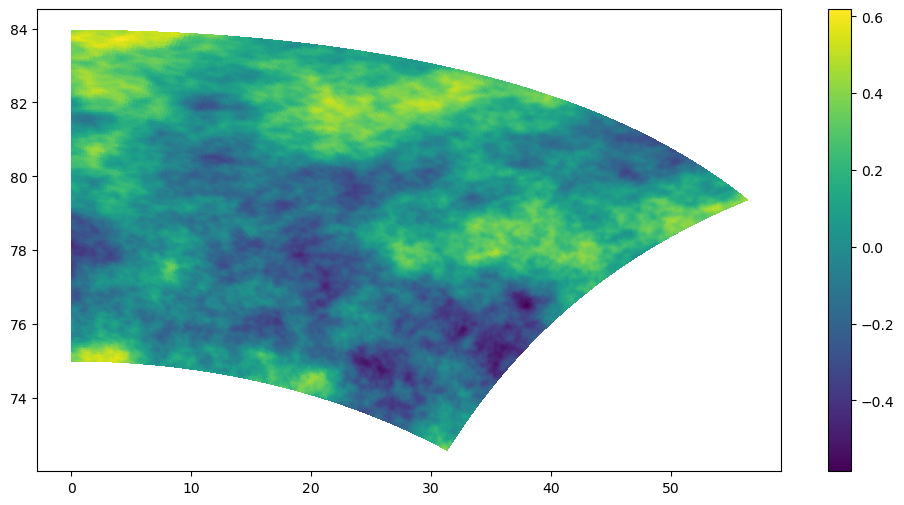

In [21]:
import matplotlib as mpl

plt.rcParams['figure.figsize'] = [12, 6]
triang = mpl.tri.Triangulation(xcoord, ycoord, tri)

plt.tripcolor(triang, tt)
plt.colorbar()

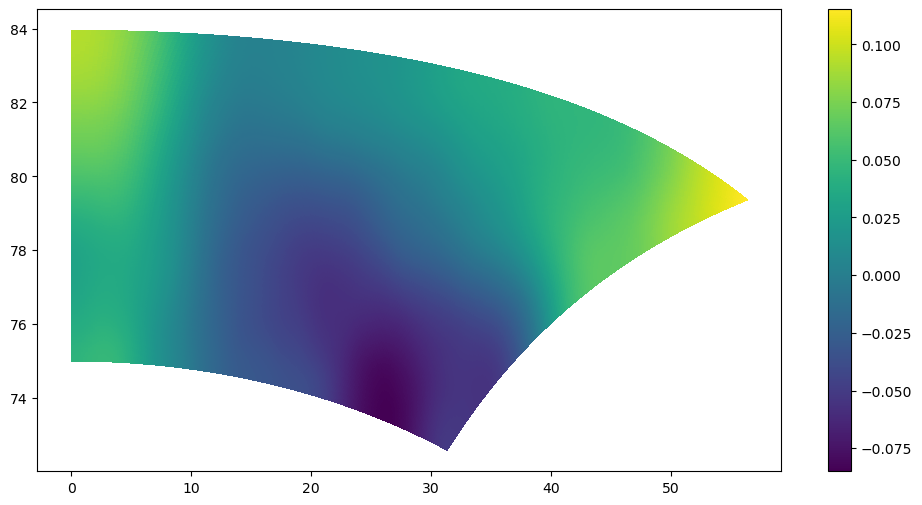

In [22]:
plt.tripcolor(triang, tts)
plt.colorbar()

In [26]:
def scale_A_by_spectral_radius(A):

    if A.layout == torch.sparse_csc:

        absA = torch.absolute(A)
        m, n = absA.shape
        row_sum = absA @ torch.ones(n, 1, dtype=A.dtype, device=A.device)
        col_sum = torch.ones(1, m, dtype=A.dtype, device=A.device) @ absA
        gamma = torch.min(torch.max(row_sum), torch.max(col_sum))
        outA = A * (1. / gamma.item())

    elif A.layout == torch.strided:

        absA = torch.absolute(A)
        row_sum = torch.sum(absA, dim=1)
        col_sum = torch.sum(absA, dim=0)
        gamma = torch.min(torch.max(row_sum), torch.max(col_sum))
        outA = A / gamma

    else:

        raise NotImplementedError(
            'A must be either torch.sparse_csc_tensor or torch.tensor')

    return outA

In [29]:
from GNP import GNP
from ResGCN import ResGCN
from GMRES import GMRES
import torch

n = 1 # Filter order
device = torch.device("cpu")
solver = GMRES()
tmp = torch.tensor(np.array(ss) * (1.0 / np.square(Kc[-1])), device=device)
Smat1 = csc_matrix((ss * (1.0 / jnp.square(Kc[-1])), (ii, jj)), shape=(n2d, n2d))
Smat = identity(n2d) + 0.5 * (Smat1 ** n)

In [35]:
num_layers = 8              # number of layers in GNP
embed = 32                  # embedding dimension in GNP
hidden = 64                 # hidden dimension in MLPs in GNP
drop_rate = 0.0             # dropout rate in GNP
disable_scale_input = False # whether disable the scaling of inputs in GNP
dtype = torch.float64       # training precision for GNP
lr = 2e-3                   # learning rate in training GNP
weight_decay = 0.0          # weight decay in training GNP
training_data = 'x_mix'     # type of training data x
m = 80                      # Krylov subspace dimension for training data
batch_size = 64             # batch size in training GNP
grad_accu_steps = 1         # gradient accumulation steps in training GNP
epochs = 2000               # number of epochs in training GNP

In [36]:
A = torch.sparse_csc_tensor(Smat.indptr, Smat.indices, Smat.data, Smat.shape, dtype=torch.float64).to(device)
A = scale_A_by_spectral_radius(A)
net = ResGCN(A, num_layers, embed, hidden, drop_rate, scale_input=True, dtype=dtype).to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = None
M = GNP(A, training_data, m, net, device)

In [ ]:
import time 

tic = time.time()
hist_loss, best_loss, best_epoch, model_file = M.train(
    batch_size, grad_accu_steps, epochs, optimizer, scheduler, num_workers=4,
    checkpoint_prefix_with_path="./tmp_", progress_bar=True)

print(f'Done. Training time: {time.time()-tic} seconds')
print(f'Loss: inital = {hist_loss[0]}, final = {hist_loss[-1]}, best = {best_loss}, epoch = {best_epoch}')
print(f'Best model saved in {model_file}')



Train:   0%|          | 0/2000 [00:00<?, ?it/s]

Train loss 1.1e-01:   0%|          | 0/2000 [00:29<?, ?it/s]

Train loss 1.1e-01:   0%|          | 1/2000 [00:29<16:09:41, 29.11s/it]

Train loss 1.1e-01:   0%|          | 1/2000 [00:50<16:09:41, 29.11s/it]

Train loss 1.1e-01:   0%|          | 2/2000 [00:50<13:41:15, 24.66s/it]

Train loss 1.1e-01:   0%|          | 2/2000 [01:12<13:41:15, 24.66s/it]

Train loss 1.1e-01:   0%|          | 3/2000 [01:12<12:58:58, 23.40s/it]

Train loss 1.1e-01:   0%|          | 3/2000 [01:33<12:58:58, 23.40s/it]

Train loss 1.1e-01:   0%|          | 4/2000 [01:33<12:19:36, 22.23s/it]

Train loss 1.1e-01:   0%|          | 4/2000 [01:53<12:19:36, 22.23s/it]

Train loss 1.1e-01:   0%|          | 5/2000 [01:53<11:58:08, 21.60s/it]

Train loss 1.1e-01:   0%|          | 5/2000 [02:14<11:58:08, 21.60s/it]

Train loss 1.1e-01:   0%|          | 6/2000 [02:14<11:47:59, 21.30s/it]

Train loss 1.0e-01:   0%|          | 6/2000 [02:35<11:47:59, 21.30s/it]

Train loss 

In [41]:
print(f'Loading model from {"./tmp_epoch_1999.pt"} ...')
net.load_state_dict(torch.load("./tmp_epoch_1999.pt", map_location=device, weights_only=True))
M = GNP(A, training_data, m, net, device)
print('Done.')

Loading model from ./tmp_epoch_1999.pt ...
Done.


In [42]:
ttt = torch.tensor(np.array(tt), device=device, dtype=torch.float64)

### No preconditioner

In [45]:
%%time
ttw = ttt - A @ ttt  # Work with perturbations
    
x, iters, _, _, _ = solver.solve(A=A, b=ttw, rtol=1e-6, max_iters=20000, progress_bar=False)
print("Iteration " + str(iters))
x += ttt
tts = x.cpu().numpy()

Iteration 13055
CPU times: user 22.5 s, sys: 4.47 ms, total: 22.5 s
Wall time: 21.7 s


### With preconditioner

In [ ]:
%%time
ttw = ttt - A @ ttt  # Work with perturbations
    
x, iters, _, _, _ = solver.solve(A=A, b=ttw, rtol=1e-6, max_iters=20000, progress_bar=False, M=M)
print("Iteration " + str(iters))
x += ttt
tts = x.cpu().numpy()